# **Pokemón Diffusion Overfitting<a id="top"></a>**

<i><small>**Alumno:** Alejandro Pequeño Lizcano</small></i></div>

---

**Objetivo:** 
Este notebook tiene como objetivo forzar el overfitting de un modelo de difusión para poder analizar su comportamiento y entender cómo se comporta en un entorno controlado y poder arreglar posibles fallos en el código.

- [0. Imports](#-0.-Imports)

- [1. Dataset](#-1.-Dataset)
    - [1.1. Predataset](##-1.1.-Predataset)
    - [1.2. Dataset](##-1.2.-Dataset)

- [2. Modelo de Difusión](#-2.-Modelo-de-Difusión)
    - [2.1. Forward Diffusion](##-2.1.-Forward-Diffusion)
    - [2.2. Reverse Diffusion](##-2.2.-Reverse-Diffusion)
    - [2.3. Train Diffusion Model](##-2.3.-Train-Diffusion-Model)

---

# 0. Imports

In [1]:
# Import necessary libraries
# =====================================================================

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Import libraries for data preprocessing
import numpy as np
import pandas as pd
from tqdm.auto import trange, tqdm  # progress bar

# Import libraries for data and folder manipulation
import random
import os
import sys
import json
import re
import glob

# Import libraries from tensorflow for building the model
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
import gc
from sklearn.preprocessing import LabelBinarizer

# Import necessary libraries
# =====================================================================
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import configparser
import tensorflow as tf

# Import src code
from src.data.create_dataset import *
from src.model.build_unet import build_unet
from src.utils.utils import PROJECT_DIR, DATA_PATH
from src.visualization import visualize

# from src.model.diffusion_model import *
from src.model.overfitting_test import *

/home/pqlza/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-15 22:23:09.748129: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-15 22:23:09.779825: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Use the GPU
# =====================================================================
gpus_list = tf.config.list_physical_devices("GPU")
gpu = gpus_list[0]
tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs Available: ", gpus_list)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-04-15 22:23:11.725092: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-15 22:23:11.729510: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-15 22:23:11.729653: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(PROJECT_DIR / "config.ini")

# Hyperparameters
config_hp = config["hyperparameters"]

IMG_SIZE = 64
NUM_CLASSES = int(config_hp["num_classes"])
BATCH_SIZE = 32
EPOCHS = 100
T = 500
BETA_START = float(config_hp["beta_start"])
BETA_END = float(config_hp["beta_end"])
s = float(config_hp["s"])  # scale factor for the variance curve
SCHEDULER = config_hp["scheduler"]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # TODO: ADD TO CONFIG FILE
loss_fn = tf.keras.losses.MeanSquaredError()

2024-04-15 22:23:12.714288: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-15 22:23:12.714437: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-15 22:23:12.714506: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
# load df and data_dict
# =====================================================================
path = f"{DATA_PATH}/processed/pokedex_cleaned.csv"
df = pd.read_csv(path)

with open(f"{DATA_PATH}/interim/pokemon_dict_dataset.json", "r") as f:
    data_dict = json.load(f)

from src.data.path_loader import PathLoader as pl

loader = pl(
    load_pattern=f"{DATA_PATH}/raw/sprites/**/front/**/*.png",
)

# Load the paths from the file
image_paths = loader.load_paths()

from src.data.create_dataset import dataset_dict

data_dict = dataset_dict(image_paths=image_paths, df=df)

Loading paths...

- Number of paths loaded: 8143



- The shape of the dataset is: (32, 64, 64, 3) => batch_size: 32, height: 64, width: 64, channels: 3
- The shape of the dataset labels is: (32, 18) => batch_size: 32, number of labels: 18


2024-04-15 22:23:15.376482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


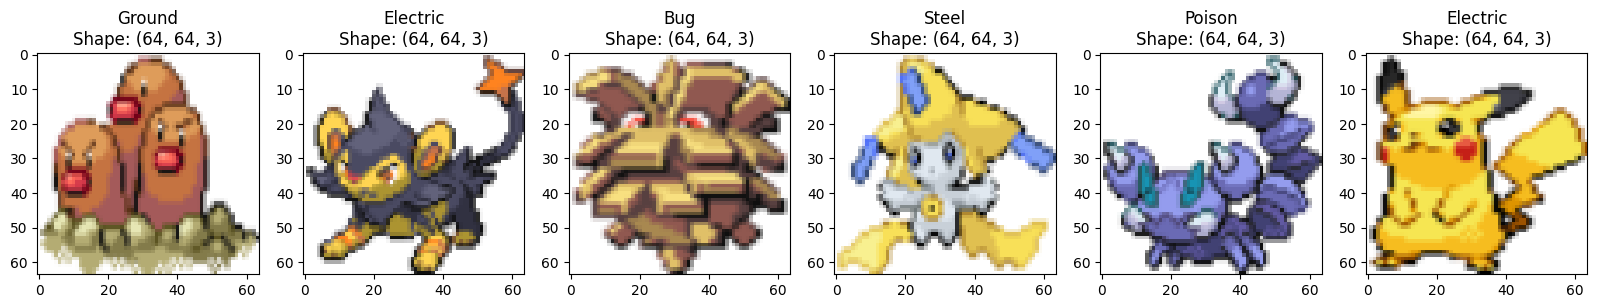

2024-04-15 22:23:15.918051: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
# dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset"
# poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

poke_dataset = dataset_tf(
    df=df,
    dict_dataset=data_dict,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

# Visualize the dataset
visualize.plot_images_batch(dataset_tf=poke_dataset, n=6)

<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(32, 64, 64, 3)
(32, 18)


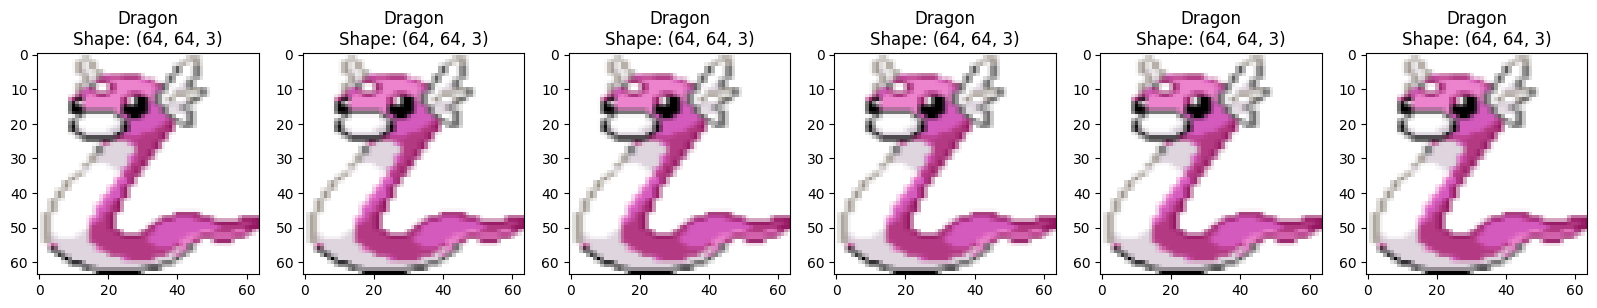

2024-04-15 22:23:34.439894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-15 22:23:34.441409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [22]:
# get one batch of the dataset
dataset_example = poke_dataset.take(1)

# get one specific image of the batch
for img, label in dataset_example:
    img_example = img[0]
    label_example = label[0]
    break

# get only one image of the dataset
for img, label in dataset_example:
    img_example = img[0]
    label_example = label[0]
    break

img_example = np.expand_dims(img_example, axis=0)  # expand the image to the batch size
label_example = np.expand_dims(
    label_example, axis=0
)  # expand the label to the batch size

dataset_example = tf.data.Dataset.from_tensor_slices((img_example, label_example))

dataset_example = dataset_example.repeat(512).batch(BATCH_SIZE)

for img, label in dataset_example:
    print(type(img), type(label))
    print(img.shape)
    print(label.shape)
    break

for img, label in dataset_example.take(1):
    visualize.plot_images_batch(dataset_tf=dataset_example)

In [23]:
# Create the model
# =====================================================================
u_net = build_unet(IMG_SIZE, NUM_CLASSES)
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = DiffusionModel(
    u_net, IMG_SIZE, NUM_CLASSES, T, BETA_START, BETA_END, s, SCHEDULER
)

# Compile the model
# =====================================================================
model.compile(loss=loss_fn, optimizer=optimizer)

Epoch 1/100


2024-04-15 22:23:47.784274: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
2024-04-15 22:23:49.789148: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.33GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 309ms/step - loss: 1.0818
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 309ms/step - loss: 0.7799
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - loss: 0.5517
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - loss: 0.4759

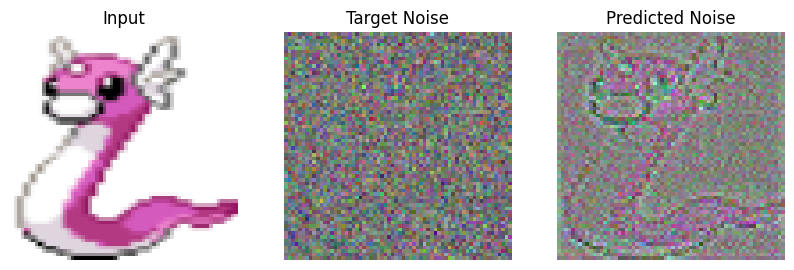

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.4479
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - loss: 0.2730
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - loss: 0.2305
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.3806
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: 0.3148

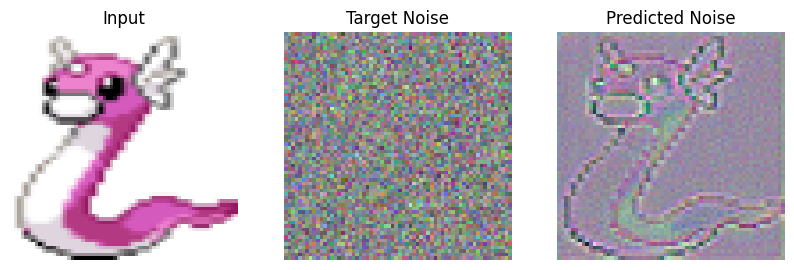

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - loss: 0.2963
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.1672
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.1671
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.1612
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 0.1664

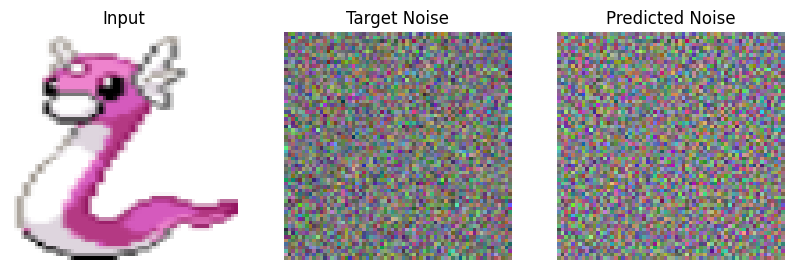

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - loss: 0.1566
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.1714
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - loss: 0.1097
Epoch 15/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.1459
Epoch 16/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - loss: 0.1301

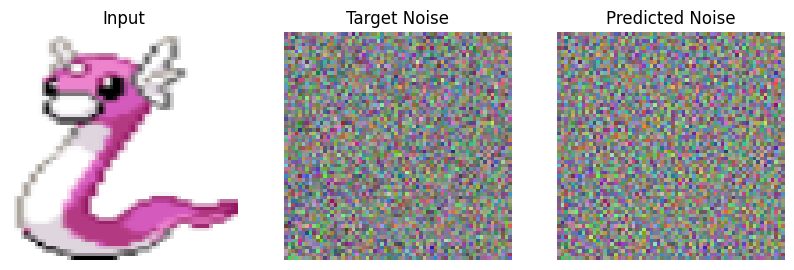

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.1225
Epoch 17/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step - loss: 0.2126
Epoch 18/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.1170
Epoch 19/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 322ms/step - loss: 0.2439
Epoch 20/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 0.1285

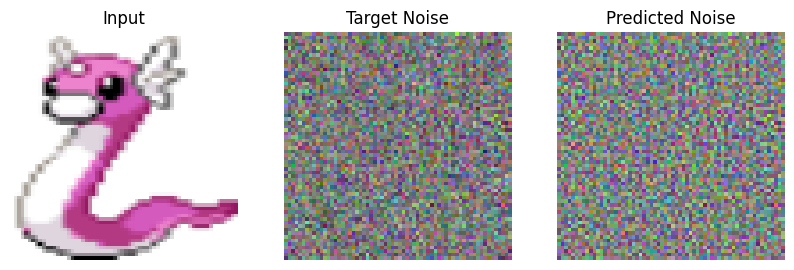

Epoch 20: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 499/499 [00:21<00:00, 23.12it/s]


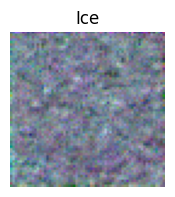

16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - loss: 0.1209  
Epoch 21/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 320ms/step - loss: 0.1421
Epoch 22/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 316ms/step - loss: 0.0997
Epoch 23/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - loss: 0.1361
Epoch 24/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - loss: 0.0798

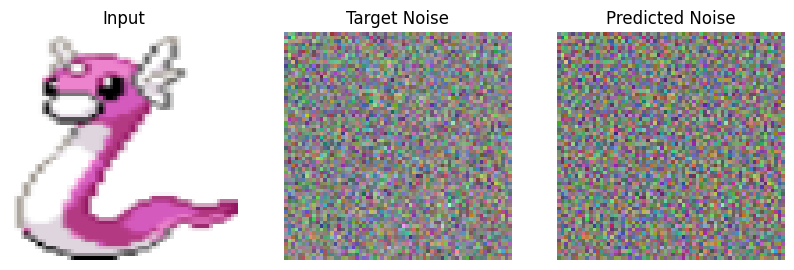

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 332ms/step - loss: 0.0751
Epoch 25/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 329ms/step - loss: 0.1424
Epoch 26/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 336ms/step - loss: 0.1363
Epoch 27/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 331ms/step - loss: 0.2305
Epoch 28/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - loss: 0.3020

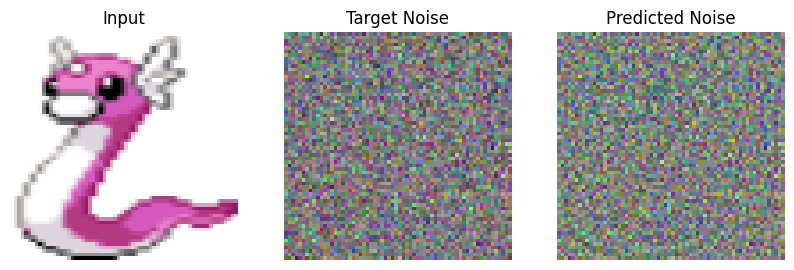

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 332ms/step - loss: 0.2842
Epoch 29/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 329ms/step - loss: 0.2206
Epoch 30/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 335ms/step - loss: 0.1609
Epoch 31/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 337ms/step - loss: 0.1513
Epoch 32/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - loss: 0.1301

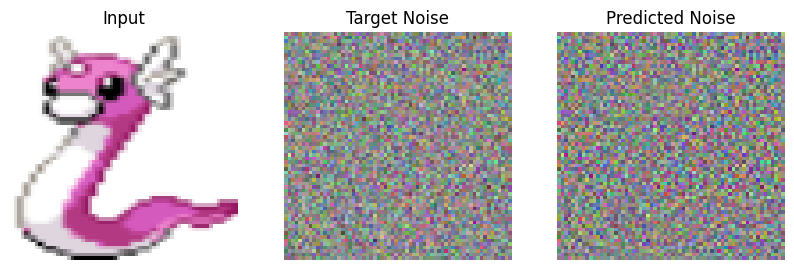

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 340ms/step - loss: 0.1224
Epoch 33/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 338ms/step - loss: 0.0795
Epoch 34/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - loss: 0.0699
Epoch 35/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - loss: 0.0879
Epoch 36/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - loss: 0.0901

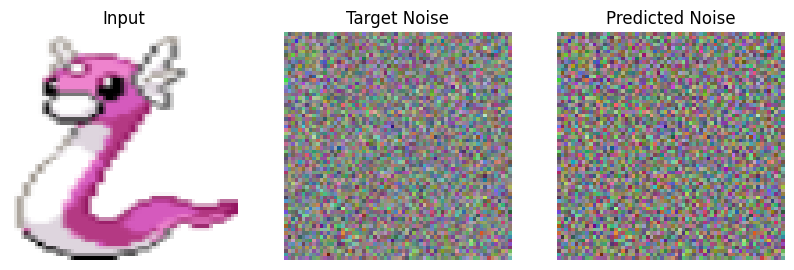

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 335ms/step - loss: 0.0848
Epoch 37/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 335ms/step - loss: 0.0823
Epoch 38/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 332ms/step - loss: 0.1143
Epoch 39/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 331ms/step - loss: 0.1381
Epoch 40/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - loss: 0.1028

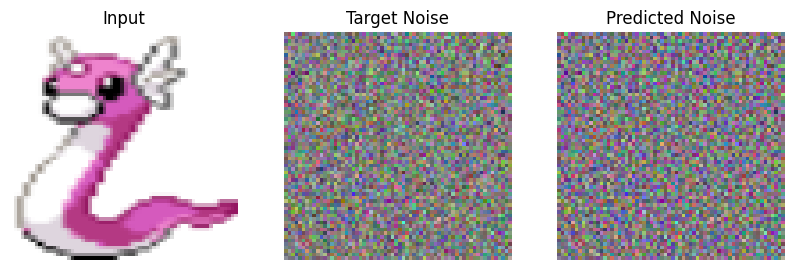

Epoch 40: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 499/499 [00:21<00:00, 22.82it/s]


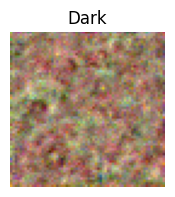

16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - loss: 0.0968  
Epoch 41/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 330ms/step - loss: 0.0780
Epoch 42/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 330ms/step - loss: 0.0728
Epoch 43/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 331ms/step - loss: 0.0813
Epoch 44/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - loss: 0.1659

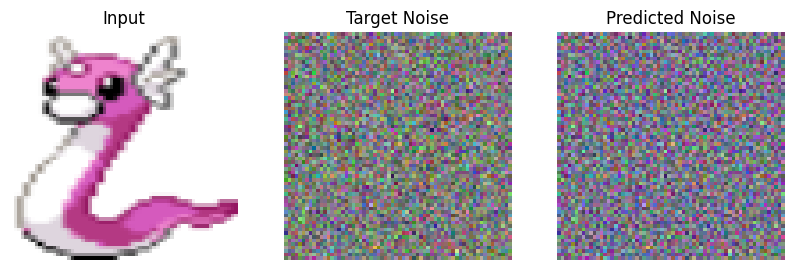

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 331ms/step - loss: 0.1562
Epoch 45/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 333ms/step - loss: 0.1577
Epoch 46/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 329ms/step - loss: 0.2206
Epoch 47/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 328ms/step - loss: 0.2122
Epoch 48/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - loss: 0.1408

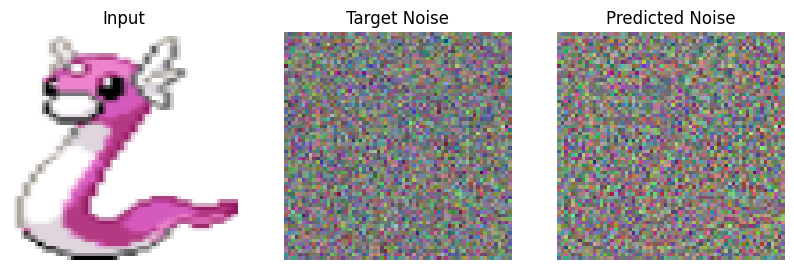

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 333ms/step - loss: 0.1325
Epoch 49/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 328ms/step - loss: 0.1787
Epoch 50/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 332ms/step - loss: 0.0726
Epoch 51/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 329ms/step - loss: 0.1459
Epoch 52/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - loss: 0.0535

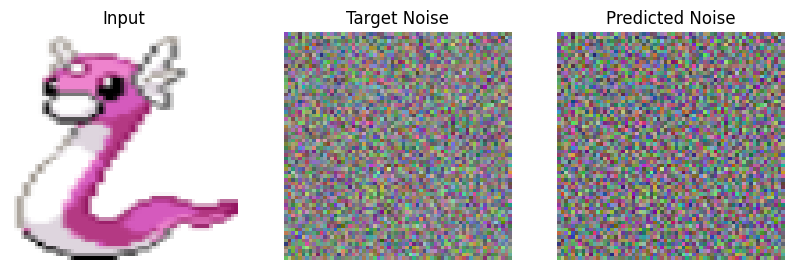

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 346ms/step - loss: 0.0503
Epoch 53/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 336ms/step - loss: 0.1267
Epoch 54/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 334ms/step - loss: 0.1123
Epoch 55/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 331ms/step - loss: 0.0563
Epoch 56/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - loss: 0.0941

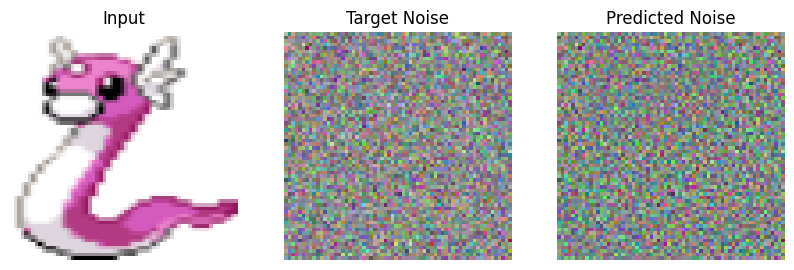

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 339ms/step - loss: 0.0886
Epoch 57/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 330ms/step - loss: 0.0705
Epoch 58/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 334ms/step - loss: 0.1118
Epoch 59/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 331ms/step - loss: 0.0945
Epoch 60/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - loss: 0.0413

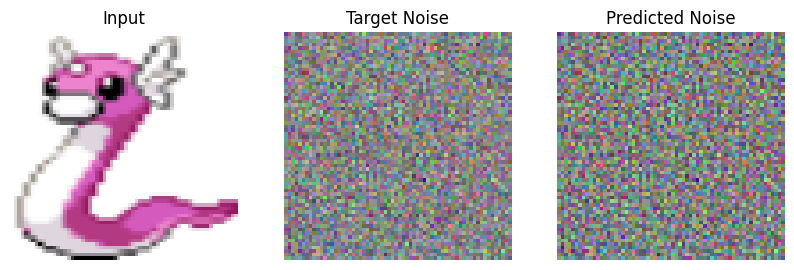

Epoch 60: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 499/499 [00:22<00:00, 21.86it/s]


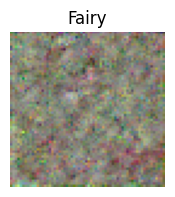

16/16 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - loss: 0.0389  
Epoch 61/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 330ms/step - loss: 0.0729
Epoch 62/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 328ms/step - loss: 0.0489
Epoch 63/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 329ms/step - loss: 0.0548
Epoch 64/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - loss: 0.0632

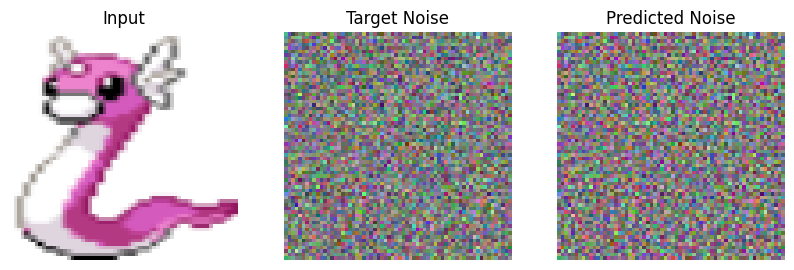

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 342ms/step - loss: 0.0595
Epoch 65/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 332ms/step - loss: 0.0469
Epoch 66/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 334ms/step - loss: 0.0382
Epoch 67/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 329ms/step - loss: 0.0788
Epoch 68/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - loss: 0.0915

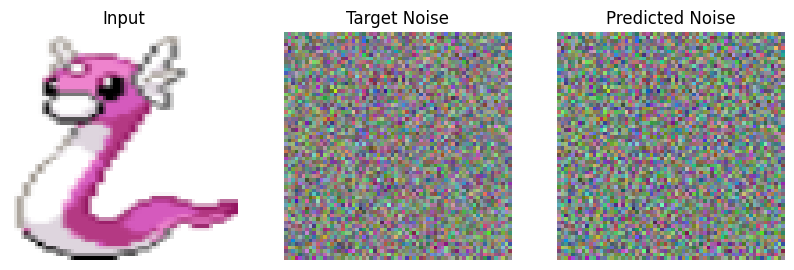

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 341ms/step - loss: 0.0861
Epoch 69/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 328ms/step - loss: 0.0481
Epoch 70/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 328ms/step - loss: 0.0709
Epoch 71/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 333ms/step - loss: 0.0892
Epoch 72/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - loss: 0.0531

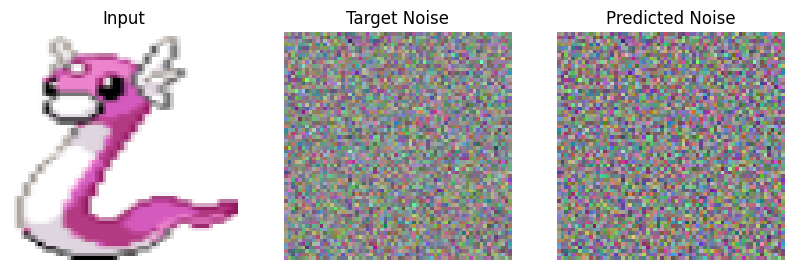

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 333ms/step - loss: 0.0500
Epoch 73/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 326ms/step - loss: 0.0596
Epoch 74/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 339ms/step - loss: 0.0675
Epoch 75/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 335ms/step - loss: 0.0731
Epoch 76/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - loss: 0.1164

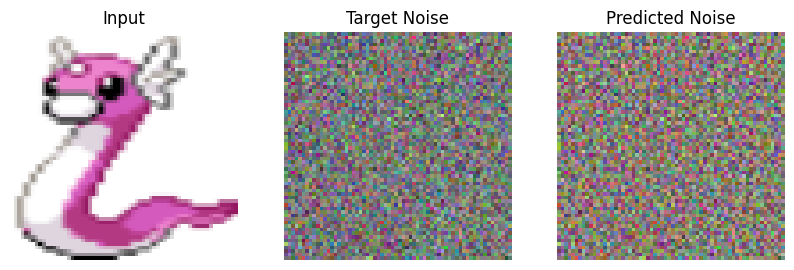

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 341ms/step - loss: 0.1095
Epoch 77/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 337ms/step - loss: 0.0791
Epoch 78/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 332ms/step - loss: 0.0394
Epoch 79/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 334ms/step - loss: 0.0842
Epoch 80/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - loss: 0.0663

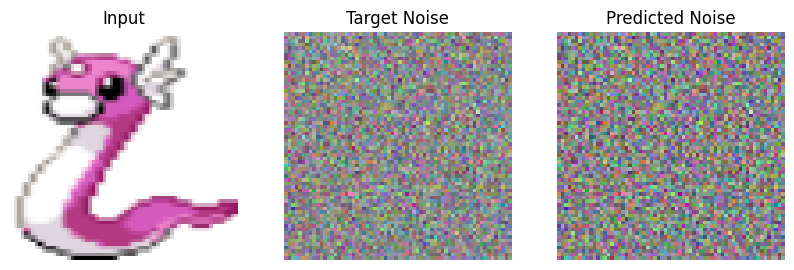

Epoch 80: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 499/499 [00:23<00:00, 21.65it/s]


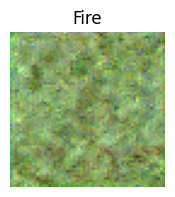

16/16 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - loss: 0.0624  
Epoch 81/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 329ms/step - loss: 0.1353
Epoch 82/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 333ms/step - loss: 0.0949
Epoch 83/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 331ms/step - loss: 0.0862
Epoch 84/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - loss: 0.0420

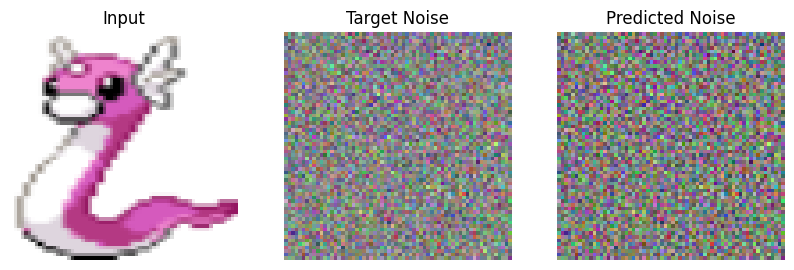

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 335ms/step - loss: 0.0396
Epoch 85/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 332ms/step - loss: 0.0395
Epoch 86/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 333ms/step - loss: 0.0433
Epoch 87/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 335ms/step - loss: 0.0290
Epoch 88/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - loss: 0.0457

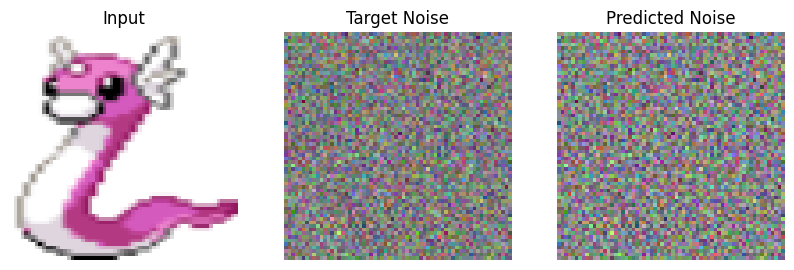

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 344ms/step - loss: 0.0430
Epoch 89/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 334ms/step - loss: 0.0439
Epoch 90/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 342ms/step - loss: 0.0914
Epoch 91/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 340ms/step - loss: 0.1125
Epoch 92/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - loss: 0.0370

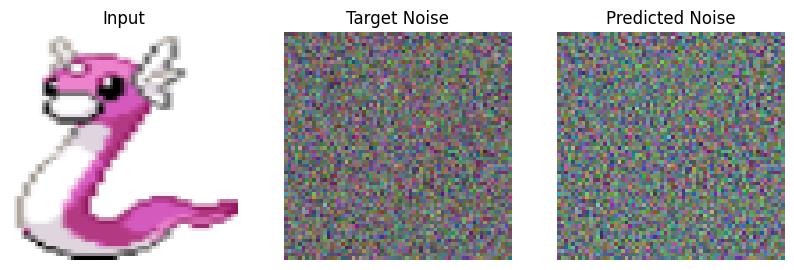

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 329ms/step - loss: 0.0348
Epoch 93/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - loss: 0.0565
Epoch 94/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 330ms/step - loss: 0.0408
Epoch 95/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 338ms/step - loss: 0.0406
Epoch 96/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - loss: 0.0386

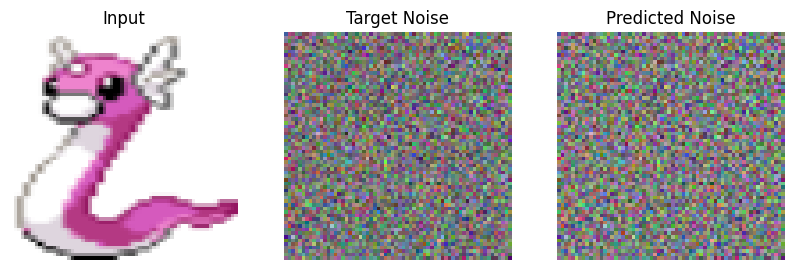

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 341ms/step - loss: 0.0363
Epoch 97/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 338ms/step - loss: 0.0858
Epoch 98/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 342ms/step - loss: 0.0476
Epoch 99/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 336ms/step - loss: 0.0344
Epoch 100/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - loss: 0.0278

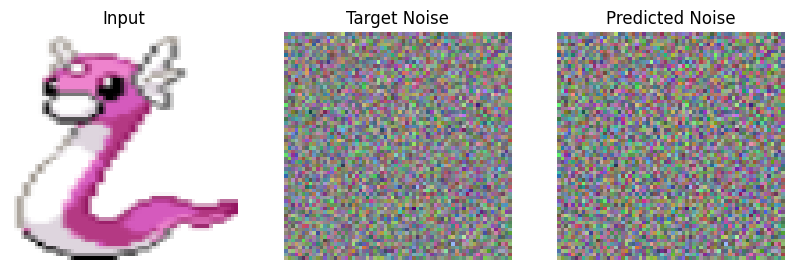

Epoch 100: Generating samples.
Generating sample 1/1


Sampling sprite: 100%|██████████| 499/499 [00:24<00:00, 20.57it/s]


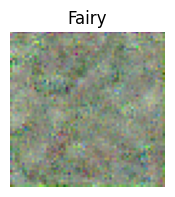

16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - loss: 0.0261  


In [25]:
tf.config.run_functions_eagerly(True)  # to debug the model
model.fit(
    dataset_example,
    epochs=EPOCHS,
    callbacks=[PlottingCallback(model, 4), DiffusionCallback(model, 20)],
)
# model.fit(poke_dataset, epochs=EPOCHS, callbacks=[DiffusionCallback(model, 10)])

Generating sample 1/1


Sampling sprite: 100%|██████████| 499/499 [00:23<00:00, 21.00it/s]


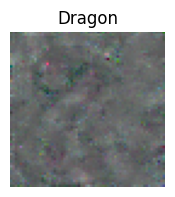

In [26]:
model.plot_samples(1, "Dragon")

Generating sample 1/6


Sampling sprite: 100%|██████████| 499/499 [00:23<00:00, 21.03it/s]


Generating sample 2/6


Sampling sprite: 100%|██████████| 499/499 [00:23<00:00, 21.44it/s]


Generating sample 3/6


Sampling sprite: 100%|██████████| 499/499 [00:23<00:00, 21.36it/s]


Generating sample 4/6


Sampling sprite: 100%|██████████| 499/499 [00:23<00:00, 21.49it/s]


Generating sample 5/6


Sampling sprite: 100%|██████████| 499/499 [00:23<00:00, 21.42it/s]


Generating sample 6/6


Sampling sprite: 100%|██████████| 499/499 [00:23<00:00, 21.32it/s]


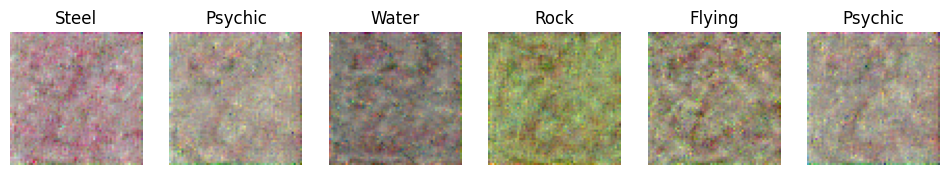

In [29]:
model.plot_samples(6)

In [ ]:
# df = preprocess.load_csv("../../dataset/pokedex.csv")
# data_path = preprocess.load_paths_from_file("../../dataset/image_paths.json")
# data_dict = preprocess.dataset_dict(data_path, df)
# dataset = preprocess.create_dataset(data_dict, df, size=IMG_SIZE, batch_size=BATCH_SIZE)
# label_mappping = preprocess.create_label_mapping(df)

# def generate_em(num_classes: int = NUM_CLASSES) -> np.ndarray:
#     """Generates a random embedding (label)

#     :param num_classes: The number of classes
#     """

#     em = np.zeros(num_classes)
#     em[np.where(label_example[0] == 1)[0][0]] = 1
#     return em


# generate_em()
# plotter.onehot_to_string(generate_em(), label_mappping)